In [23]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt  # viz
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  # векторизация текстов
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF  # dimred
import re
import pandas as pd
import warnings

In [24]:
warnings.filterwarnings("ignore")

data = pd.read_csv("istoriya.csv")
data = data.values.tolist() # превращаем в список 
data = [''.join(x) for x in data]
n_samples = len(data)  # размер корпуса
n_features = 1000  # максимальное количество слов в матрице "слово x документ" (= top1000 частотных их всех в корпусе)
n_components = 10  # число тем в корпусе
n_top_words = 20  # порог частотности для визуализаций

In [25]:

stop_words = set(stopwords.words("russian"))
lemmatizer = WordNetLemmatizer()
morph = MorphAnalyzer()

def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

In [26]:
for i in range(len(data) - 1):  # предобработка текста
    data[i] = data[i].replace(u'\xa0', u' ')
    data[i] = data[i].lower()
    data[i] = re.sub(r'\d+', '', data[i])
    translator = str.maketrans('', '', string.punctuation)
    data[i] = data[i].translate(translator)
    data[i] = " ".join(data[i].split())
    word_tokens = word_tokenize(data[i])
    data[i] = [word for word in word_tokens if word not in stop_words]
    data[i] = ' '.join(data[i])
    data[i] = lemmatize(data[i])
    data[i] = ' '.join(data[i])


print("Количество документов ", len(data))
print(data[0])


Количество документов  992
это повредить деталь старое механизм обнаружить год античный корабль затонуть близ остров андикитира антикитер приблизительно –х год наш эра мера изучение обнаружить деталь механизм стать понятно представлять себя фрагмент древний аналоговый компьютер предназначить отслеживание дата вычисление положение астрономический тело расчёт важный дата предстоящий солнечный лунный затмение также олимпийский игра антикитерский механизм уцелеть целиком удаться идентифицировать фрагмент который позволять делать вывод устройство предназначение основа антикитерский механизм — это система взаимосвязанный шестерной приводить друг друг движение прокручивание один помощь вращаться ручка устройство малый мера шестерной внешне антикитерский механизм представлять себя деревянный короб бронзовый панель циферблат спереди сзади это интересно наука происхождение антикитерский механизм — загадка поскольку исторический источник прямой упоминание часть учёный предполагать мочь собранный 

In [27]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,  # игнорируем слова,которые только в 1 доке или в 95% документов.
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(data)

print(tf.shape)  # матрица "слова x документы"

print(tf_vectorizer.get_feature_names()[996:1000])

(992, 1000)
['являться', 'язык', 'япония', 'яркий']


In [28]:

lda = LatentDirichletAllocation(n_components=n_components, max_iter=20, learning_offset=50)

lda.fit(tf)

print(lda.components_.shape)

(10, 1000)


In [29]:

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15))  # параметры отображения
    axes = axes.flatten()
    all_features = {}  # словарь для сохранения ключевых слов для тем

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь

        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.show()

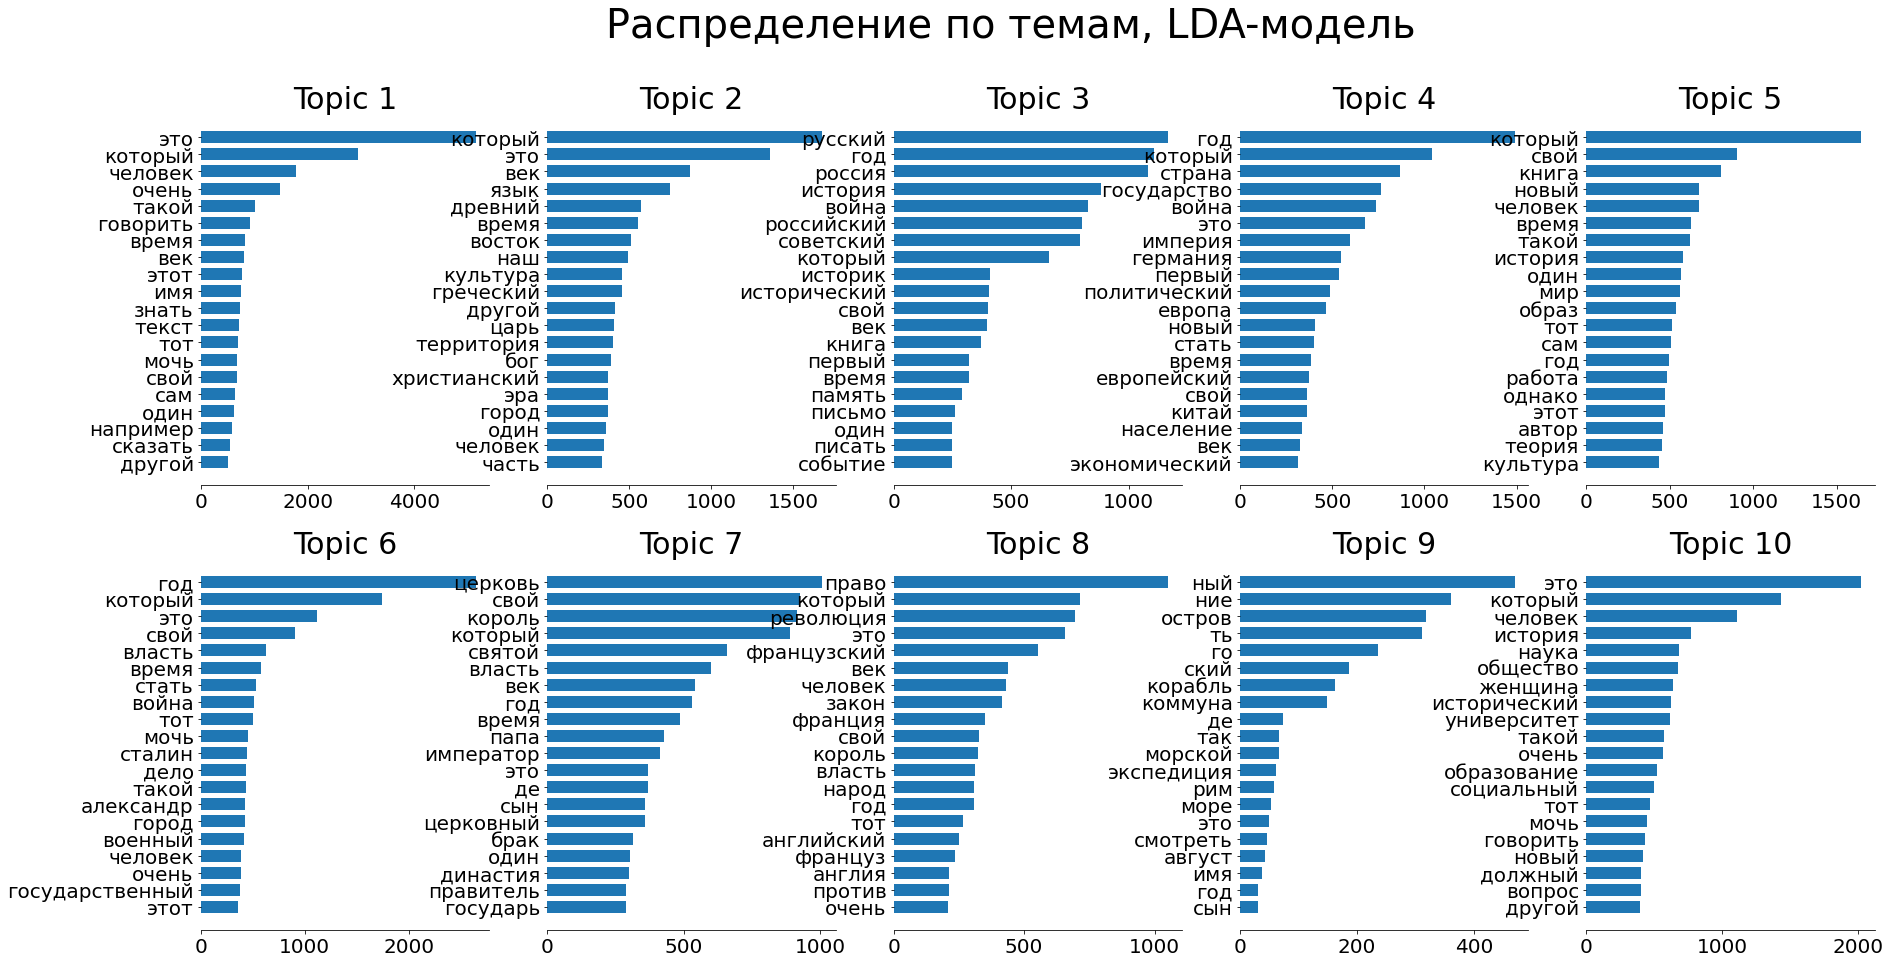

In [30]:

tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lda, tf_feature_names, n_top_words, 'Распределение по темам, LDA-модель')



In [31]:
def print_top_words(model, feature_names, n_top_words):
    all_features = {}

    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))


print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
это который человек очень такой говорить время век этот имя знать текст тот мочь свой сам один например сказать другой
Topic #1:
который это век язык древний время восток наш культура греческий другой царь территория бог христианский эра город один человек часть
Topic #2:
русский год россия история война российский советский который историк исторический свой век книга первый время память письмо один писать событие
Topic #3:
год который страна государство война это империя германия первый политический европа новый стать время европейский свой китай население век экономический
Topic #4:
который свой книга новый человек время такой история один мир образ тот сам год работа однако этот автор теория культура
Topic #5:
год который это свой власть время стать война тот мочь сталин дело такой александр город военный человек очень государственный этот
Topic #6:
церковь свой король который святой власть век год время папа император это де сын церковный брак один династия правитель госу

In [32]:
doc_topic = lda.transform(tf)

for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax() + 1
    print("doc: {} topic: {}\n".format(n, topic_most_pr))

doc: 0 topic: 2

doc: 1 topic: 6

doc: 2 topic: 10

doc: 3 topic: 10

doc: 4 topic: 1

doc: 5 topic: 10

doc: 6 topic: 10

doc: 7 topic: 10

doc: 8 topic: 8

doc: 9 topic: 10

doc: 10 topic: 5

doc: 11 topic: 1

doc: 12 topic: 10

doc: 13 topic: 1

doc: 14 topic: 10

doc: 15 topic: 10

doc: 16 topic: 10

doc: 17 topic: 10

doc: 18 topic: 5

doc: 19 topic: 2

doc: 20 topic: 3

doc: 21 topic: 4

doc: 22 topic: 10

doc: 23 topic: 1

doc: 24 topic: 5

doc: 25 topic: 4

doc: 26 topic: 5

doc: 27 topic: 3

doc: 28 topic: 3

doc: 29 topic: 3

doc: 30 topic: 1

doc: 31 topic: 5

doc: 32 topic: 5

doc: 33 topic: 1

doc: 34 topic: 1

doc: 35 topic: 1

doc: 36 topic: 6

doc: 37 topic: 8

doc: 38 topic: 3

doc: 39 topic: 1

doc: 40 topic: 5

doc: 41 topic: 6

doc: 42 topic: 6

doc: 43 topic: 7

doc: 44 topic: 2

doc: 45 topic: 5

doc: 46 topic: 7

doc: 47 topic: 7

doc: 48 topic: 2

doc: 49 topic: 10

doc: 50 topic: 3

doc: 51 topic: 2

doc: 52 topic: 7

doc: 53 topic: 6

doc: 54 topic: 3

doc: 55

In [33]:
print(doc_topic)

[[4.44568177e-04 4.64429383e-01 4.44535245e-04 ... 4.44533841e-04
  2.00082794e-02 4.44573369e-04]
 [5.02664547e-04 2.46213142e-01 5.02630589e-04 ... 5.02616203e-04
  5.02540946e-04 5.02651896e-04]
 [2.38167575e-03 2.38155418e-03 3.32411911e-01 ... 2.38146468e-03
  2.38117578e-03 6.48535380e-01]
 ...
 [9.34883338e-04 4.86911197e-01 9.34812207e-04 ... 9.34878299e-04
  9.34644807e-04 3.96162727e-01]
 [1.55198265e-01 2.27836832e-04 3.69598006e-02 ... 2.27829606e-04
  2.27819336e-04 4.31140107e-01]
 [2.97099108e-01 2.08376674e-03 2.08418594e-03 ... 2.08409109e-03
  2.08352359e-03 1.55177668e-01]]


In [34]:
lsa_model = TruncatedSVD(n_components=n_components)

lsa_topic_matrix = lsa_model.fit_transform(tf)

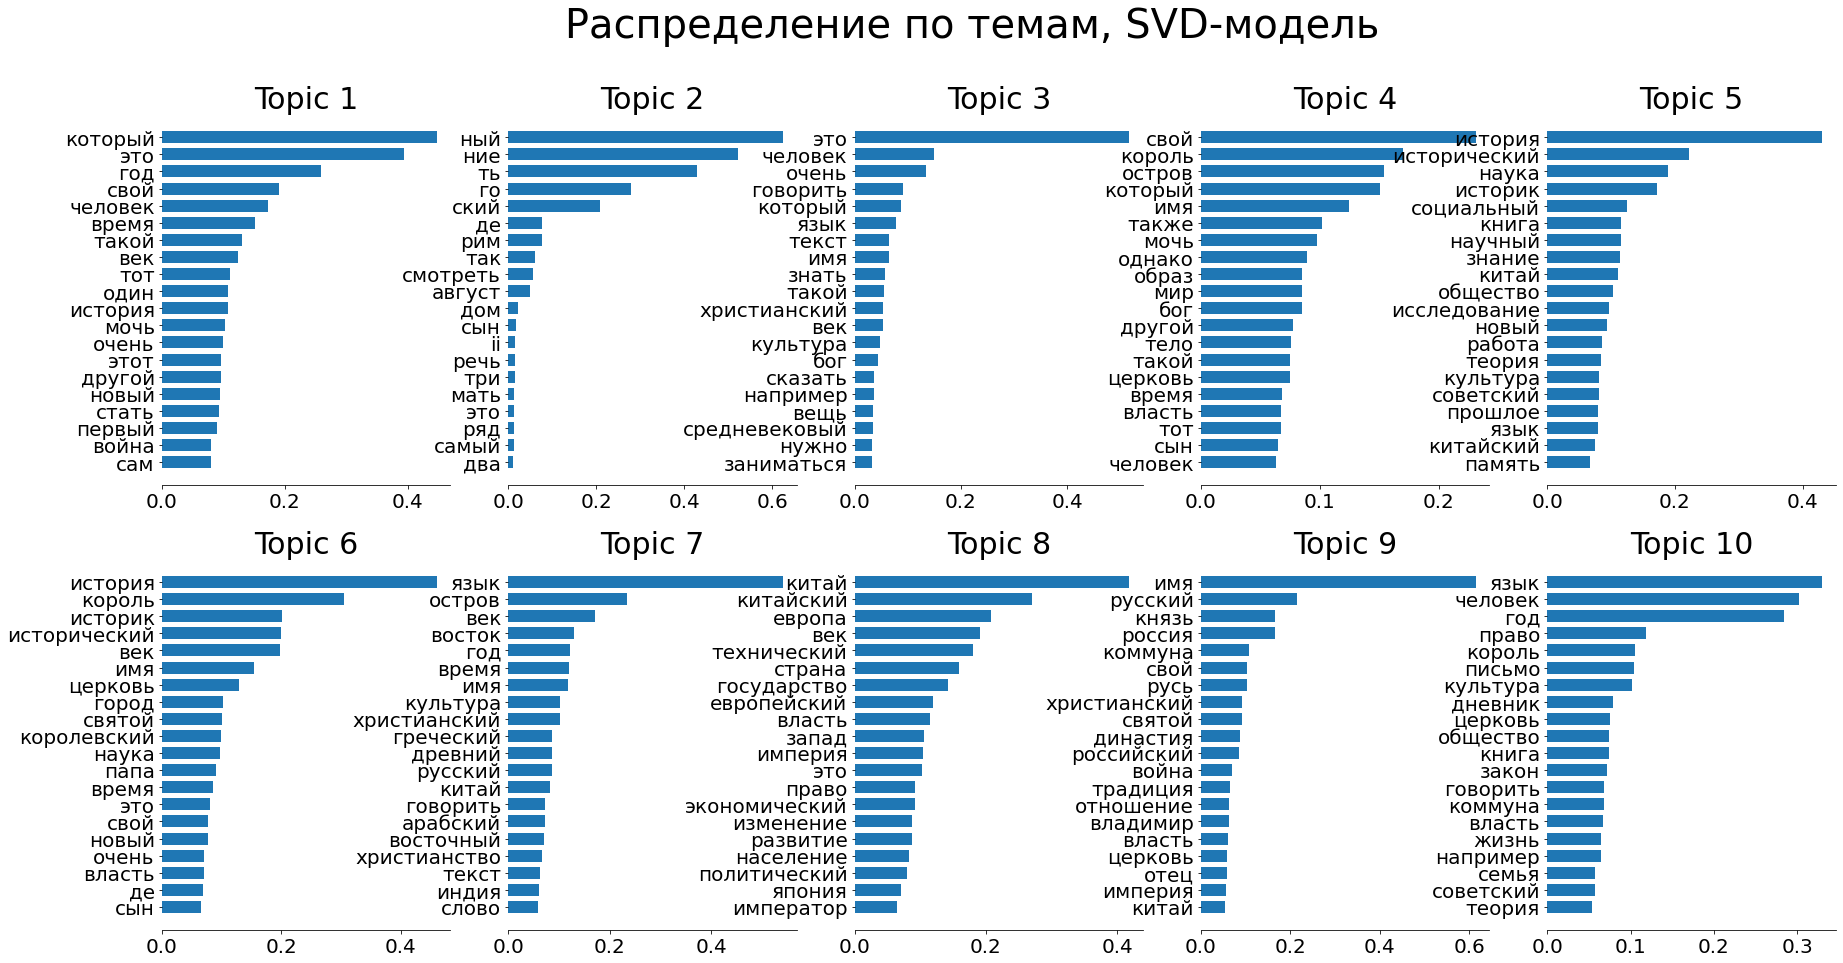

In [35]:
tf_feature_names = tf_vectorizer.get_feature_names()

plot_top_words(lsa_model, tf_feature_names, n_top_words, 'Распределение по темам, SVD-модель')

In [36]:
# для NMF понадобится tf-idf-векторизация, тк tf-idf не бывает негативным

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data)

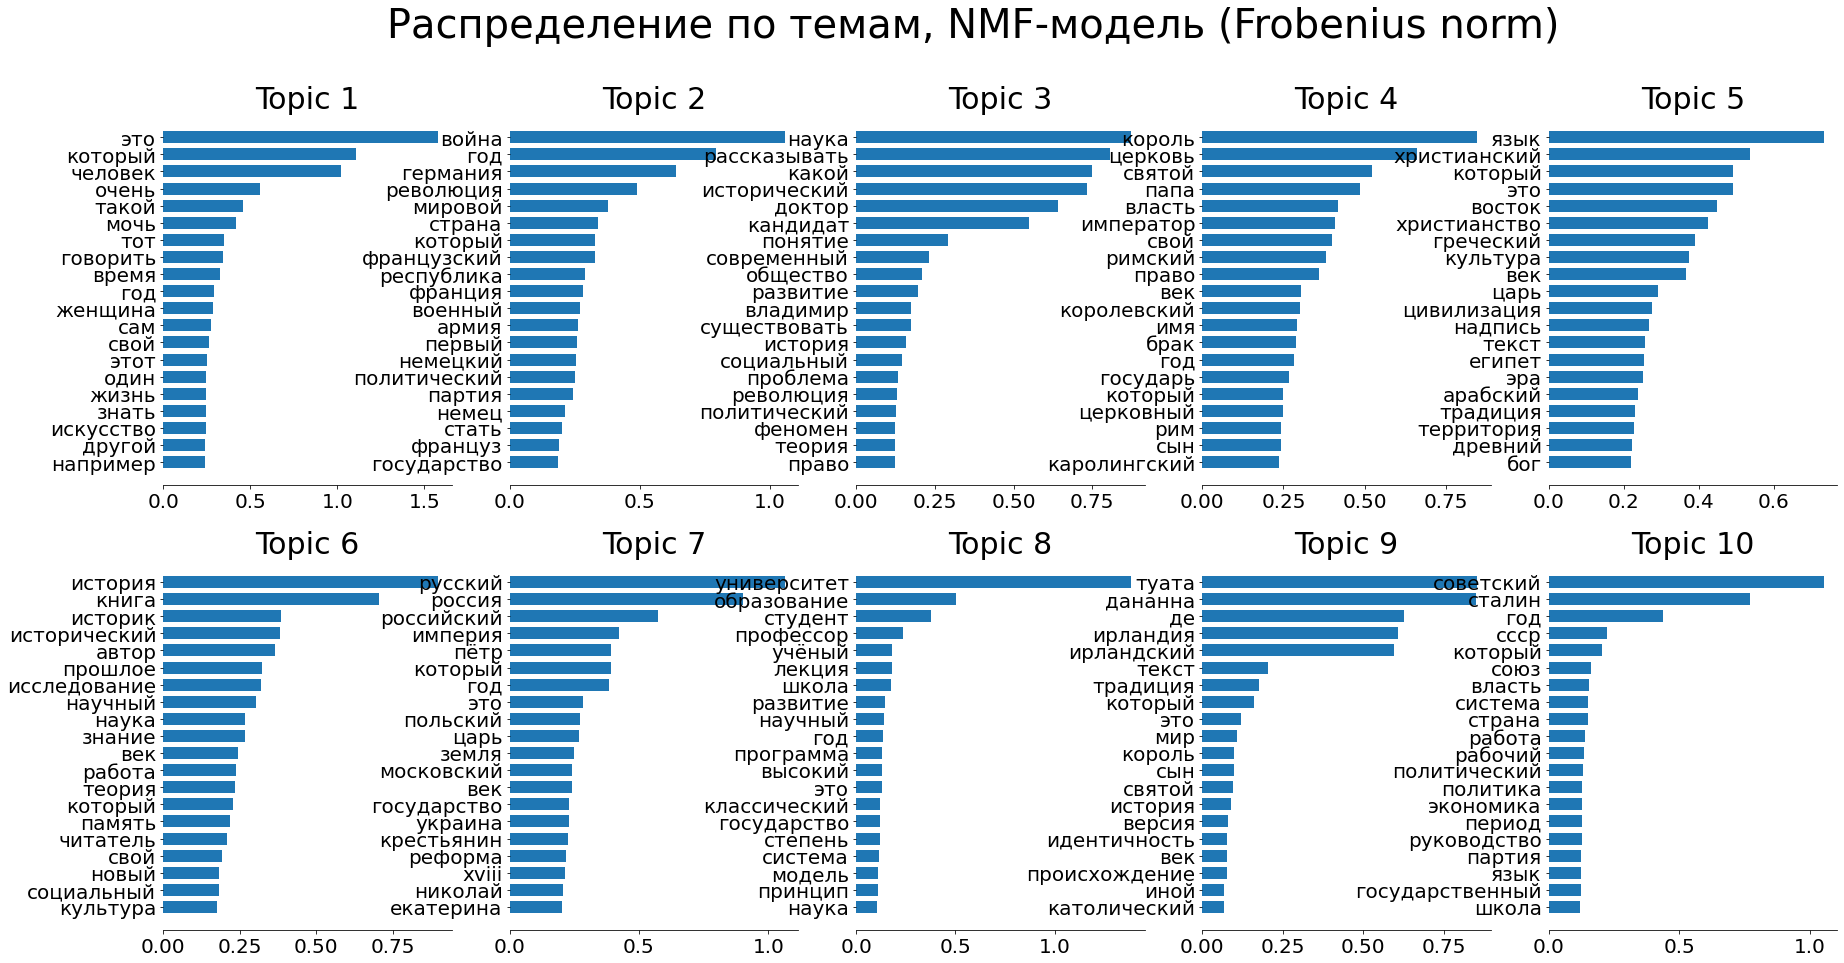

In [37]:
nmf = NMF(n_components=n_components).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель (Frobenius norm)')

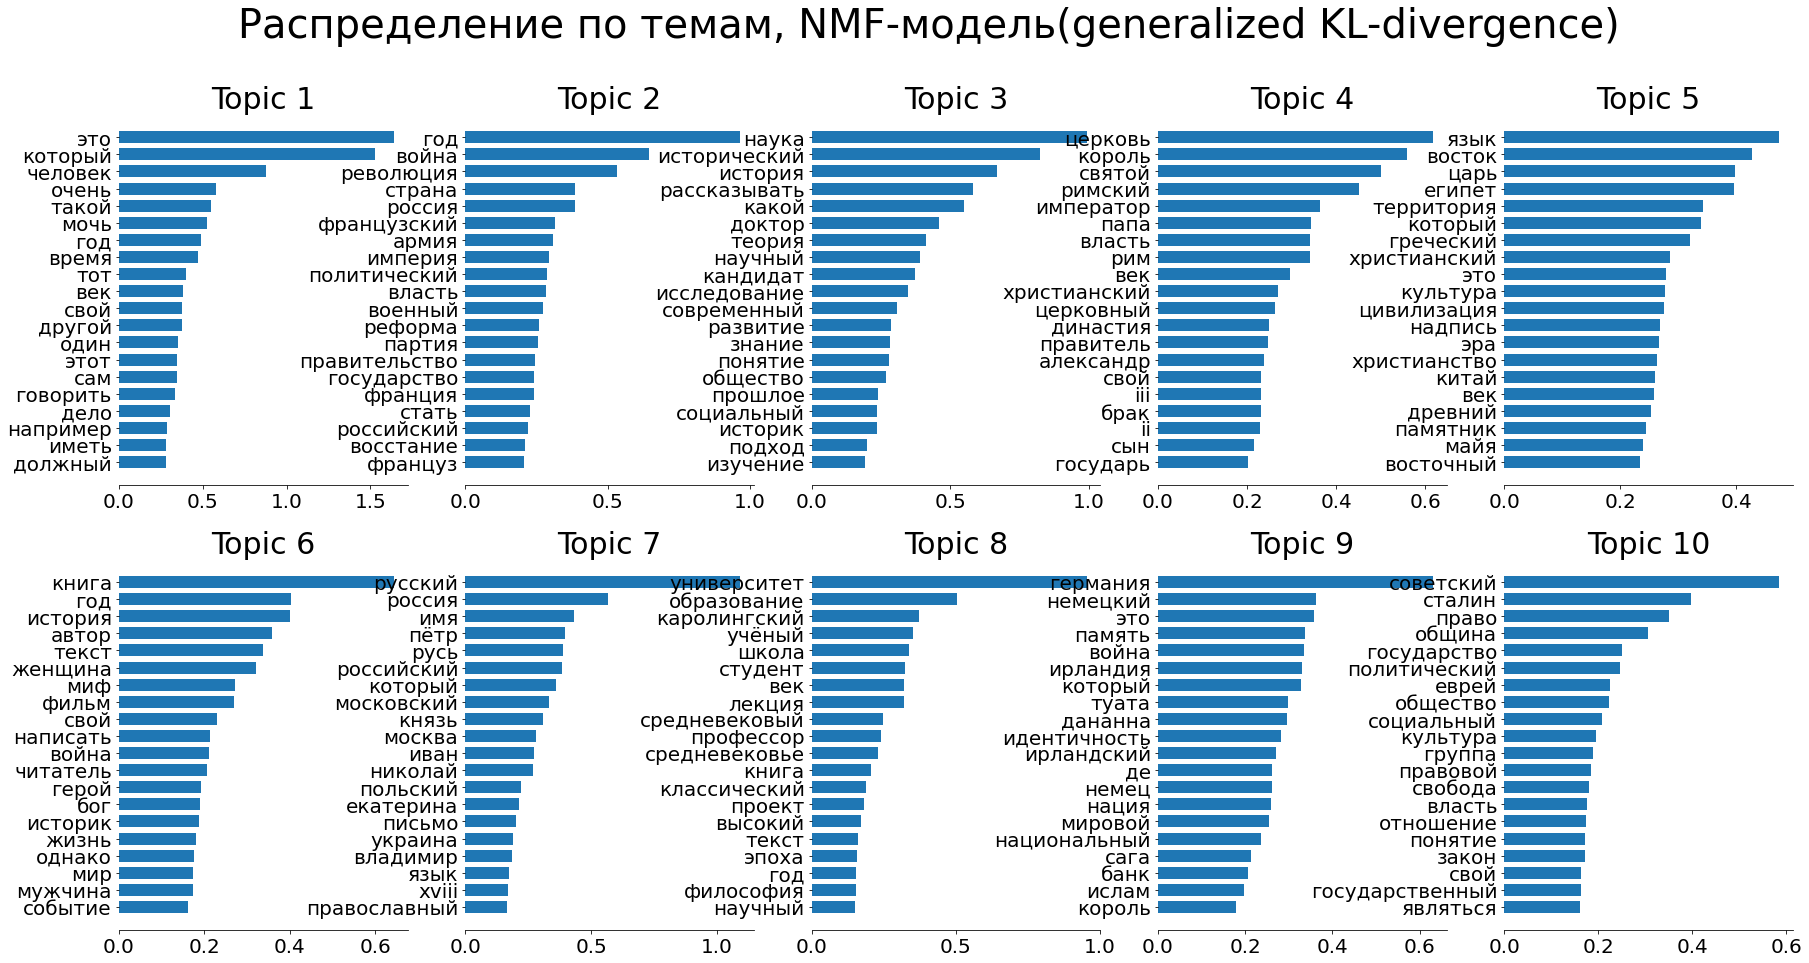

In [38]:
nmf = NMF(n_components=n_components, beta_loss='kullback-leibler', solver='mu').fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Распределение по темам, NMF-модель(generalized KL-divergence)')